## Objectives
Forecast the influx of tourist in Hauts-de-France using Vector Auto Regressive modelization

Ensure and verify the quality of our prediction ability through Error reduction analysis using Forward Chaining (Cross Validation)

## Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyramid.arima import auto_arima

## Datasets

In [2]:
nights = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/nights_2010-2017.csv', index_col='date', parse_dates=['date'], 
                          usecols=[*range(1, 15)])
temp = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
daysoff = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('/Users/sekou/Documents/GitHub/touristcast/datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])

# - Filtering data on Bourgogne Franche Comté Region
region_code = 'HDF'

# df with data for training set
data_region = pd.concat([nights, temp, daysoff, gdp], axis=1)
data_region = data_region.dropna()
data_region = data_region[['nights_'+region_code,'gdp_'+region_code,'daysoff','avgtemp_'+region_code]]

# df with nights only for testing set
nights_region = nights[['nights_'+region_code]]

## Properties 

To use VAR modelization, we need to have an non-stationary data => Time series decomposition needed to implement our model

Seasonality type : **Additive** for exogeneous and endogeneous variables
 
 **Exogeneous variable** : Temperature, Daysoff

 **Endogeneous variable** : Residual data of TS decomposition Nights, GDP

In [4]:
#Endogeneous variables dataset
endog_GES = pd.concat([nights, gdp], axis=1)
endog_GES = endog_GES.dropna()
endog_GES = endog_GES[['nights_GES','gdp_GES']]

# df with exog data for training set
exog_GES = pd.concat([temp, daysoff], axis=1)
exog_GES = exog_GES[['avgtemp_GES','daysoff']]     # DF format for seasonal decompose

# df with nights only for testing set
nights_GES = nights[['nights_GES']]

## Forward Chaining (Cross-Validation for Time Series)¶
Metrics used : RMSE (Root Mean Squared Error) & Mean Absolute Error

Forecasting 12 lags (12 months) at every loop starting 2010 to 2016 

 **Best Hyperparameter found for VAR lags is : 7** (based on RMSE analysis)

Years of training data: ['2010', '2011']
Predicted year: 2012-01-01
VAR lag order: 1
RMSE test: 282.5017062953793
MAE test: 280.4943487725771
-------
Years of training data: ['2010', '2011', '2012']
Predicted year: 2013-01-01
VAR lag order: 1
RMSE test: 86.09195925073381
MAE test: 80.44743442521086
-------
Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2014-01-01
VAR lag order: 1
RMSE test: 135.05486335079985
MAE test: 129.99644158959467
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2015-01-01
VAR lag order: 1
RMSE test: 69.8334383936879
MAE test: 63.4719304967212
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015']
Predicted year: 2016-01-01
VAR lag order: 1
RMSE test: 104.58466273566566
MAE test: 98.36641079274908
-------
98.89123093272181
93.07055432606896
Years of training data: ['2010', '2011']
Predicted year: 2012-01-01
VAR lag order: 2
RMSE test: 369.94421399976756
MAE test: 366.7527

Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2015-01-01
VAR lag order: 10
RMSE test: 101.52512404571657
MAE test: 87.10331521405924
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015']
Predicted year: 2016-01-01
VAR lag order: 10
RMSE test: 98.89771323640512
MAE test: 83.06961127215786
-------
460.23035962441725
393.8776593477313
Years of training data: ['2010', '2011']
Predicted year: 2012-01-01
VAR lag order: 11
RMSE test: 466.54098308485356
MAE test: 461.0987576268344
-------
Years of training data: ['2010', '2011', '2012']
Predicted year: 2013-01-01
VAR lag order: 11
RMSE test: 8429.196357750016
MAE test: 4633.848197552031
-------
Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2014-01-01
VAR lag order: 11
RMSE test: 239.62404980585544
MAE test: 210.81014615468192
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2015-01-01
VAR lag order: 11
RMSE test: 211

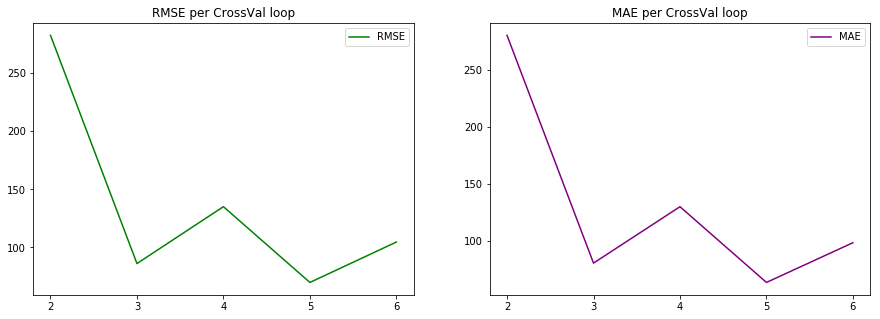

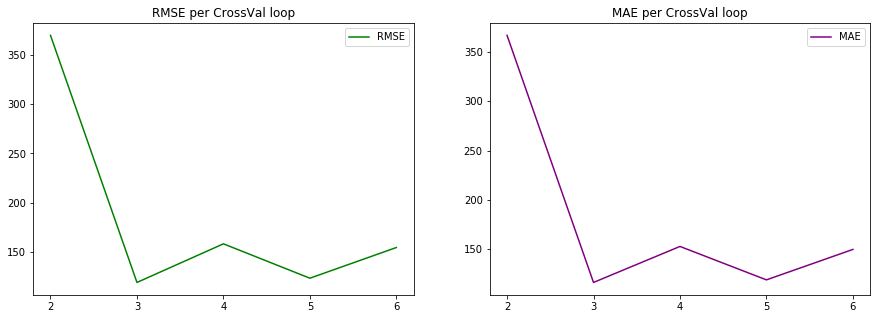

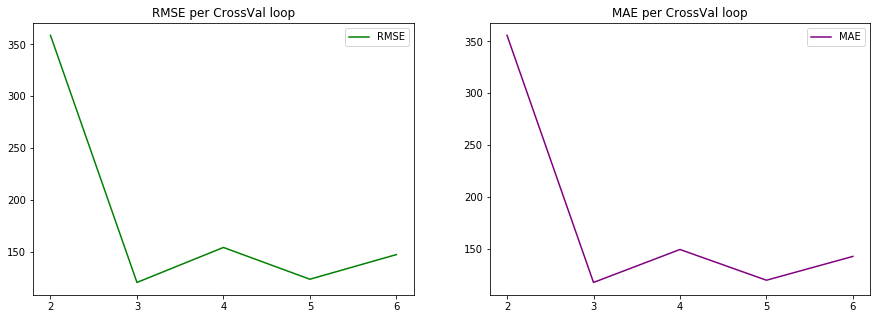

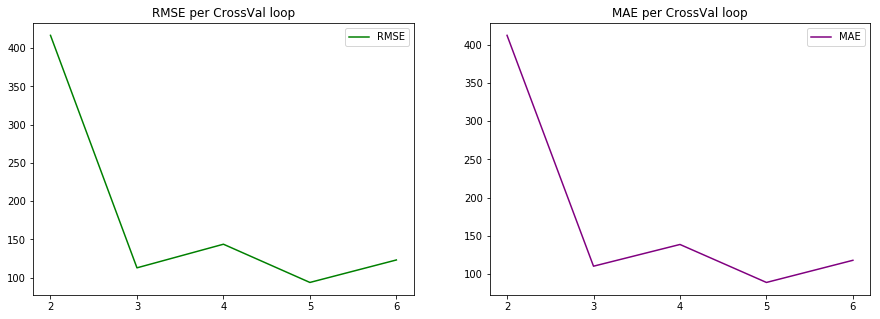

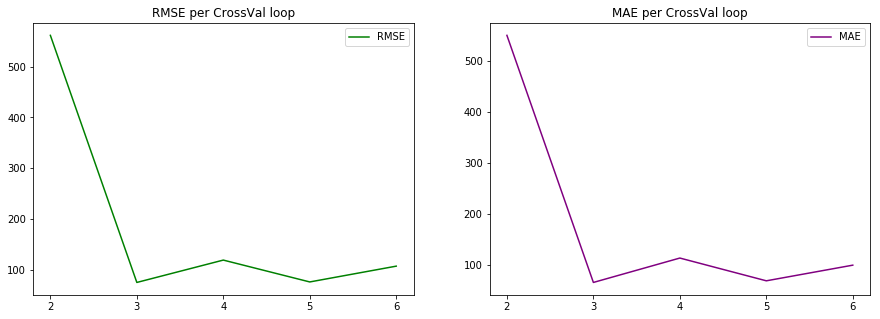

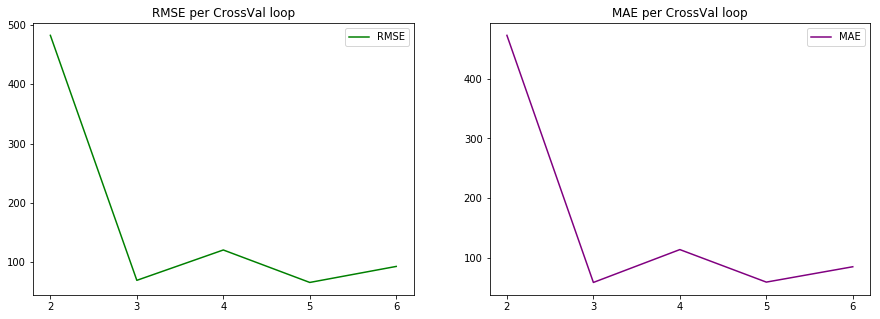

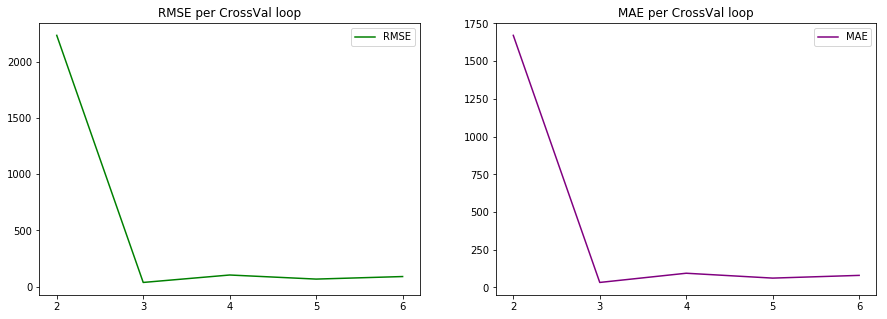

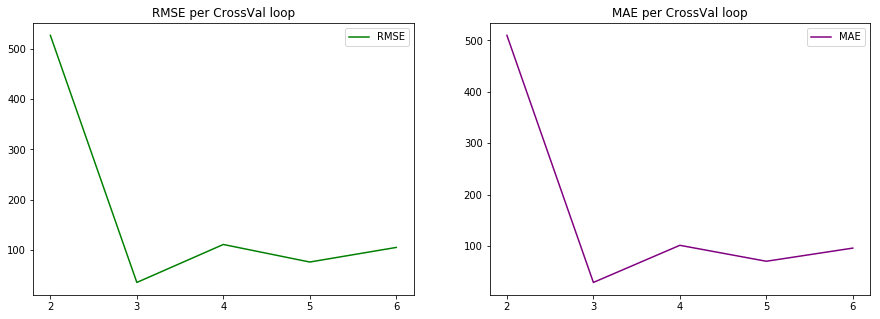

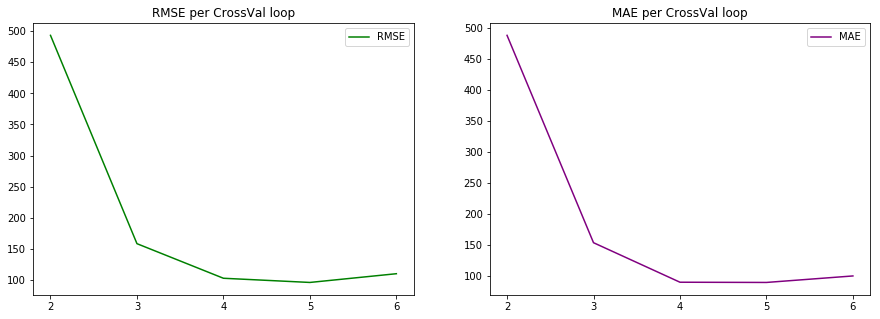

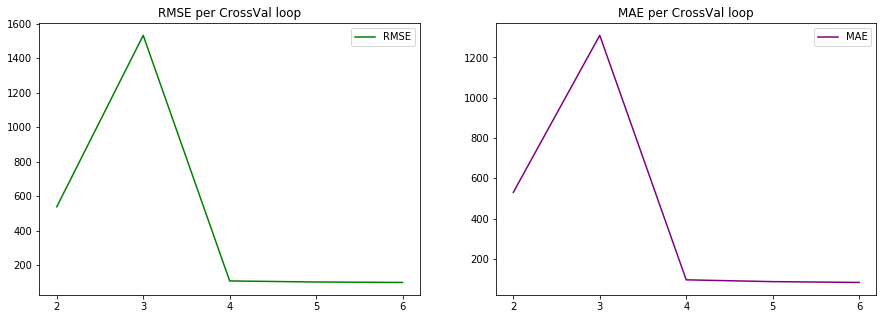

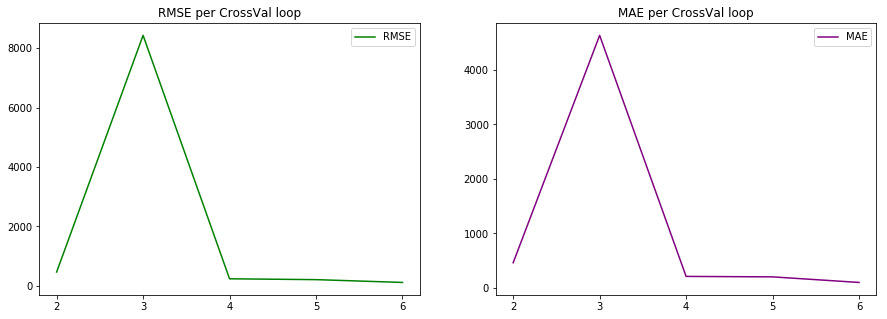

In [5]:
input_data = endog_GES         # dataframe-type dataset # Endog
target = nights_GES           # dataframe-type dataset
exog = exog_GES
start_year = '2010-01-01'     # date as string

for i in range(1, 12):
    all_mae = []
    all_rmse = []
    years_data = []
    for index in range(2012, 2017):
        end_year = str(index)+'-01-01'
        predict_year = str(index+1)+'-01-01'

        training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
        testing_period = (target.index>=end_year)&(target.index<predict_year)

        train_data = input_data[training_period]
        test_data = np.array(target[testing_period]) # Array format to calculate errors at the end

        exog_train_data = exog[(exog.index>=start_year)&(exog.index<end_year) ]
        exog_future_data = exog[(exog.index>=end_year)&(exog.index<predict_year)]

        # --------Seasonal decompose----------

        # - IMPORTANT - Change model (multiplicative or additive) based on season type of nights
        decomposed_data = seasonal_decompose(train_data, model='additive', extrapolate_trend='freq')  

        seasonal_data, trend_data, residual_data = decomposed_data.seasonal, decomposed_data.trend, decomposed_data.resid

        exog_resid = seasonal_decompose(exog_train_data, model='additive', extrapolate_trend='freq')
        exog_resid_data = exog_resid.resid

        # ---------Seasonal prediction (Same as last year of training data)---------

        # Duplicate last year's seasonal data
        seasonal_forecast = seasonal_data[(seasonal_data.index>=start_year)&(seasonal_data.index<end_year)]

        # Forecasted DF without datetime index and only 12 months to be able to recompose later
        # - IMPORTANT - Replace nights_PAC below with column name for your region
        seasonal_forecast_df = pd.DataFrame(seasonal_forecast.nights_GES.values[-12:])

        # --------Trend prediction (Linear Holt)----------

         # ARIMA model (w/ auto parameters) on nights trend
        trend_model = auto_arima(trend_data.nights_GES, 
                                 start_p=0, start_q=0, max_p=20, max_q=20, m=12, 
                                 start_P=0, max_P=20, seasonal=False, d=1, D=1, 
                                 trace=False, error_action='ignore', suppress_warnings=True, 
                                 stepwise=True, random=True, random_state=42) 

            # If using Holt: Holt(trend_data['nights_'+region_code]).fit(optimized=True)

        # Predict 12 months of trend
        trend_forecast = trend_model.predict(n_periods=12)

            # If using Holt: trend_model.predict(start=0, end=11)

        # Forecasted DF without datetime index to be able to recompose later
        trend_forecast_df = pd.DataFrame(trend_forecast) 

        # --------Residual prediction (VAR)----------

        # VAR model: Don't use maxlags, use specific lags in fit argument below
        resid_model = VAR(endog=residual_data, exog=exog_resid_data, dates=residual_data.index)
        # - IMPORTANT - Replace lag number in fit below with desired lags
        resid_results = resid_model.fit(i, trend='nc')

        lag_order = resid_results.k_ar

        # Forecasted DF without datetime index to be able to recompose later
        resid_forecast_df = pd.DataFrame(resid_results.forecast(residual_data.values[-lag_order:], 12, 
                                                                exog_future=exog_future_data))

        # --------Recomposing results----------
        # - IMPORTANT - Addition if additive series /// Multiplication if multiplicative series
        forecast = seasonal_forecast_df[0] + trend_forecast_df[0] + resid_forecast_df[0]


        # --------Calculated error measures for each CV step----------
        rmse_test = np.sqrt(mean_squared_error(test_data, forecast))
        mae_test = mean_absolute_error(test_data, forecast)

        all_rmse.append(rmse_test)
        all_mae.append(mae_test)

        years_data.append(end_year)

        print('Years of training data:', train_data.index.strftime('%Y').unique().tolist())
        print('Predicted year:', end_year)
        print('VAR lag order:', lag_order)
        print('RMSE test:', rmse_test)
        print('MAE test:', mae_test)
        print('-------')

    # Error measures per CrossVal loop (number of years of training data used)
    years_training = list(range(2,7))

    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(years_training, all_rmse, label='RMSE', color='green')
    axes[0].set_xticks(years_training)
    axes[0].set_title('RMSE per CrossVal loop')
    axes[0].legend()

    axes[1].plot(years_training, all_mae, label='MAE', color='purple')
    axes[1].set_xticks(years_training)
    axes[1].set_title('MAE per CrossVal loop')
    axes[1].legend();

    print(np.mean(all_rmse[1:]))
    print(np.mean(all_mae[1:]))
